# 计算机网络体系结构第一次作业

## 实验设置

买卖的最小单位是一手，即 100 份。

### 买入

若忽略起点，买入费率为 0.038%

- 考虑买入证券交易费：过户费、佣金
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = deltaPosition * stockToday["收盘"]
costBuy = deltaPositionValue*0.02/1e3 + max(deltaPositionValue*0.018/100, 5)
#self.cash -= deltaPosition * stockToday["收盘"]
self.cash = self.cash - deltaPositionValue - costBuy

#没有考虑self.cash不够，出现负数的情况
```

### 卖出

若忽略起点，买入费率为 0.043%

- 考虑买入证券交易费：印花税、过户费、佣金
- 印花税：单向收取，卖出成交金额的万分之五（5‱）印花税由政府收取
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = pos["头寸"] * stockToday["收盘"]
costSell = deltaPositionValue*(1e-3 + 0.02/1e3) + max(deltaPositionValue*0.018/100, 5)
```


## 实验代码及说明


### 准备依赖


In [70]:
# !python -m pip install akshare matplotlib numpy pandas PyPortfolioOpt

In [71]:
import akshare as ak
import calendar
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl
import os

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False

### 准备实验数据


In [72]:
stockNameCodes: list[tuple[str, str]] = [
    ("512200", "房地产ETF"),
    ("513050", "中概互联网ETF"),
    ("510300", "沪深300ETF"),
    ("510050", "上证50ETF"),
    ("510500", "中证500ETF"),
    ("159915", "创业板ETF"),
    ("159902", "中小100ETF"),
    ("512010", "医药ETF"),
    ("512880", "证券ETF"),
    ("512580", "环保ETF"),
    ("159920", "恒生ETF"),
    ("510900", "H股ETF"),
    ("513500", "标普500ETF"),
    ("513100", "纳指ETF"),
    ("512660", "军工ETF")
]


def Preprocess(startDate: datetime.datetime, endDate: datetime.datetime):
    # 获取标的历史数据
    startDate = startDate - datetime.timedelta(days=365)

    allStockDaily: dict[str, pd.DataFrame] = {}
    path = f'data/{startDate.strftime("%Y")}-{endDate.strftime("%Y")}'
    if os.path.exists(path):
        print(f'使用已有数据({startDate.strftime("%Y")}-{endDate.strftime("%Y")})')
        for code, name in stockNameCodes:
            stockDaily = pd.read_csv(os.path.join(
                path, f"{name}_{code}.csv"), sep=',')
            stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])
            stockDaily = stockDaily.set_index("日期", drop=False)

            allStockDaily[code] = stockDaily
        return allStockDaily

    os.makedirs(path)
    for i, (code, name) in enumerate(stockNameCodes):
        print(f"{i}. {name}({code}) 正在读取数据...")
        try:
            # stockDaily = ak.stock_zh_a_hist(
            stockDaily = ak.fund_etf_hist_em(
                symbol=code,
                period="daily",
                start_date=startDate.strftime("%Y%m%d"),
                end_date=endDate.strftime("%Y%m%d"),
                adjust="hfq",
            )
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}读取失败!'
            )
            continue
        # print(stockDaily.columns)
        stockDaily = stockDaily[stockDaily["开盘"].notnull()]
        stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])

        stockDaily.to_csv(os.path.join(
            path, f"{name}_{code}.csv"), index=False)
        stockDaily = stockDaily.set_index("日期", drop=False)

        allStockDaily[code] = stockDaily
    return allStockDaily


start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2024, 3, 14)
allStockDaily = Preprocess(start, end)
print(f"共有{len(allStockDaily)}个标的数据")

使用已有数据(2016-2024)
共有15个标的数据


### 实验内容

#### 单个 ETF 上的测试


In [73]:
# 额外费用：过户费、佣金、印花税
class ExtraCost:
    __counter = 0

    def __init__(self, silent: bool = False):
        self.__silent = silent

    def get(self):
        return self.__counter

    def buy(self, num: float, store: bool = True):
        global total_extra
        brokerage = round(num * 18 / 1e5, 2)
        if not self.__silent and brokerage < 5:
            print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
        extra = round(round(num / 5000, 2) + max(5, brokerage), 2)
        if store:
            self.__counter += extra
        return round(num + extra, 2)

    def sell(self, num: float, store: bool = True):
        assert num > 0
        global total_extra
        brokerage = round(num * 18 / 1e5, 2)
        if not self.__silent and brokerage < 5:
            print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
        extra = round(round(num / 4000, 2) + max(5, brokerage), 2)
        if store:
            self.__counter += extra
        return round(num - extra, 2)

In [74]:
def calc(stockNameCode: tuple[str, str], step: datetime.timedelta, silent: bool = False) -> tuple[float, float, float]:
    '''
    Returns a tuple of (asset, ratio)
    '''
    df = allStockDaily[stockNameCode[0]]

    # 1 表示开盘，2 表示收盘
    D = 2

    # 总期数
    periods_total: int = (df.iloc[-1, 0] - df.iloc[0, 0])//step+1
    # 剩余期数
    periods = periods_total
    # 开始时间
    cur: pd.DatetimeIndex = df.iloc[0, 0]
    # 初始资金：一百万
    INIT = 1000000
    money = INIT
    # 股票数量
    stocks = 0
    extra = ExtraCost(silent=silent)

    l = []

    i = 1
    for date, row in df.iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price: float = row[D]
        # 当前资产
        asset_now = ((money+extra.sell(stocks*price, store=False))
                     if stocks > 0 else money)/INIT
        l.append(pd.DataFrame([{'日期': date, '资产': asset_now}]))
        if cur <= date:
            # 本期准备使用的资金金额
            period_money = money/periods

            # 本期准备购买的股票数量（以 100 份为单位）
            stock_count = period_money//price//100

            # 本期准备购买的股票总价
            stock_price = stock_count*100*price
            while money < extra.buy(stock_price, store=False):
                stock_count -= 1
                stock_price = stock_count*100*price
                assert stock_count >= 0, f"剩余资金 {money} 不足以购买一手股票"
            money -= extra.buy(stock_price)
            assert money >= 0
            money = round(money, 2)
            stocks += stock_count*100
            if not silent:
                STOCK_PRICE = extra.sell(stocks*price, store=False)
                print(
                    f"第 {i} / {periods_total} 期（{date}）: {money} + {STOCK_PRICE} = {money+STOCK_PRICE}")
            cur += step
            i += 1
            periods -= 1

    if not silent:
        print(f"开始计算{stockNameCode[1]}")
        ax = plt.axes(title=stockNameCode[1])
        # 当日与首日股票价格的比例
        normalized = df.iloc[:, D]/df.iloc[0, D]
        # 不太能理解的是这个地方为什么不能正常显示标签。
        normalized.plot(ax=ax, x='日期', y='开盘', label='当日开盘价与首日开盘价的比值')

        # 资产比值
        asset = pd.DataFrame(columns=['日期', '资产'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=False, inplace=True)
        asset.plot(ax=ax, x='日期', y='资产', label='当日资产与初始资产的比值')
    price: float = df.iloc[-1, D]
    ratio: float = price/df.iloc[0, D]
    final = round(extra.sell(stocks*price), 2)
    if not silent:
        print(f"Money: {money}")
        print(f"Stock: {stocks}")
        print(f"Price: {price}")
        print(f"Price Ratio: {ratio}")
        print(f"Stock Name: {stockNameCode[1]}")
        print(f"Total Extra Cost: {extra.get()}")
        print(f"Final: {final} + {money} = {round(final+money,2)}")
    return round(final+money, 2)/INIT, ratio, extra.get()

第 1 / 27 期（2017-09-25 00:00:00）: 963030.96 + 36939.11 = 999970.07
第 2 / 27 期（2017-12-25 00:00:00）: 926040.5 + 74016.26 = 1000056.76
第 3 / 27 期（2018-03-26 00:00:00）: 889054.26 + 108564.9 = 997619.16
第 4 / 27 期（2018-06-22 00:00:00）: 852023.8 + 136969.67 = 988993.4700000001
第 5 / 27 期（2018-09-20 00:00:00）: 814970.52 + 159473.19 = 974443.71
第 6 / 27 期（2018-12-19 00:00:00）: 777967.86 + 190562.82 = 968530.6799999999
第 7 / 27 期（2019-03-19 00:00:00）: 740913.68 + 280245.94 = 1021159.6200000001
第 8 / 27 期（2019-06-17 00:00:00）: 703876.62 + 295626.32 = 999502.94
第 9 / 27 期（2019-09-16 00:00:00）: 666841.66 + 334691.42 = 1001533.0800000001
第 10 / 27 期（2019-12-16 00:00:00）: 629783.58 + 377510.0 = 1007293.58
第 11 / 27 期（2020-03-13 00:00:00）: 592751.02 + 401244.09 = 993995.1100000001
第 12 / 27 期（2020-06-11 00:00:00）: 555746.46 + 430674.73 = 986421.19
第 13 / 27 期（2020-09-09 00:00:00）: 518777.42 + 526928.32 = 1045705.74
第 14 / 27 期（2020-12-08 00:00:00）: 481789.77 + 538371.6 = 1020161.37
第 15 / 27 期（2021-0

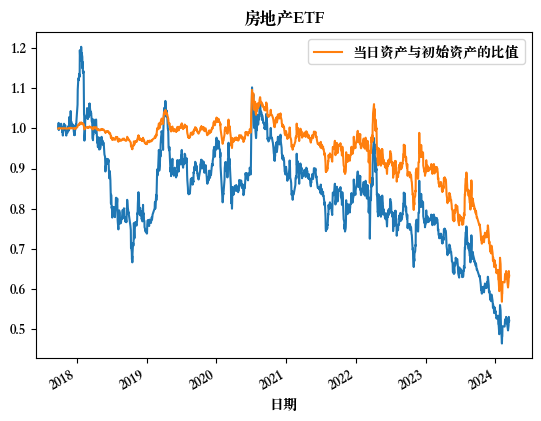

第 1 / 31 期（2016-09-01 00:00:00）: 967764.76 + 32209.14 = 999973.9
第 2 / 31 期（2016-11-30 00:00:00）: 935598.74 + 70441.5 = 1006040.24
第 3 / 31 期（2017-02-28 00:00:00）: 903383.7 + 96415.03 = 999798.73
第 4 / 31 期（2017-05-31 00:00:00）: 871241.49 + 129229.41 = 1000470.9
第 5 / 31 期（2017-08-28 00:00:00）: 839086.47 + 158993.4 = 998079.87
第 6 / 31 期（2017-11-27 00:00:00）: 806858.13 + 200193.28 = 1007051.41
第 7 / 31 期（2018-02-23 00:00:00）: 774609.48 + 232541.96 = 1007151.44
第 8 / 31 期（2018-05-24 00:00:00）: 742359.23 + 269452.09 = 1011811.3200000001
第 9 / 31 期（2018-08-22 00:00:00）: 710239.23 + 333813.8 = 1044053.03
第 10 / 31 期（2018-11-20 00:00:00）: 678067.61 + 350317.6 = 1028385.21
第 11 / 31 期（2019-02-18 00:00:00）: 645892.19 + 386316.61 = 1032208.7999999999
第 12 / 31 期（2019-05-20 00:00:00）: 613662.45 + 439073.71 = 1052736.16
第 13 / 31 期（2019-08-19 00:00:00）: 581461.42 + 489135.98 = 1070597.4
第 14 / 31 期（2019-11-15 00:00:00）: 549172.15 + 550502.19 = 1099674.3399999999
第 15 / 31 期（2020-02-13 00:00:00）:

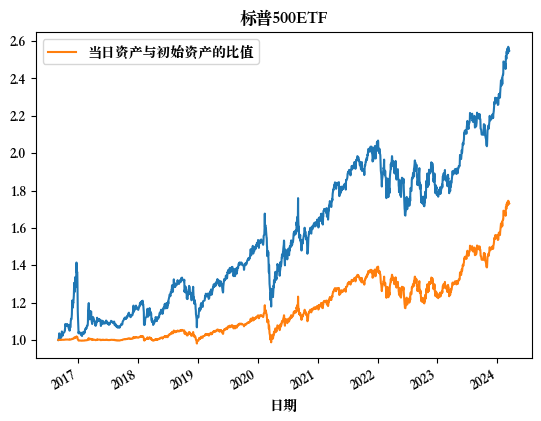

第 1 / 31 期（2016-09-01 00:00:00）: 967782.76 + 32191.15 = 999973.91
第 2 / 31 期（2016-11-30 00:00:00）: 935550.52 + 66201.52 = 1001752.04
第 3 / 31 期（2017-02-28 00:00:00）: 903280.76 + 104547.52 = 1007828.28
第 4 / 31 期（2017-05-31 00:00:00）: 871031.41 + 144899.27 = 1015930.68
第 5 / 31 期（2017-08-28 00:00:00）: 838802.97 + 172425.23 = 1011228.2
第 6 / 31 期（2017-11-27 00:00:00）: 806615.24 + 219808.34 = 1026423.58
第 7 / 31 期（2018-02-23 00:00:00）: 774442.32 + 254926.93 = 1029369.25
第 8 / 31 期（2018-05-24 00:00:00）: 742372.74 + 295358.54 = 1037731.28
第 9 / 31 期（2018-08-22 00:00:00）: 710201.32 + 367300.4 = 1077501.72
第 10 / 31 期（2018-11-20 00:00:00）: 678082.72 + 365951.37 = 1044034.09
第 11 / 31 期（2019-02-18 00:00:00）: 645936.61 + 412581.21 = 1058517.82
第 12 / 31 期（2019-05-20 00:00:00）: 613842.02 + 478603.71 = 1092445.73
第 13 / 31 期（2019-08-19 00:00:00）: 581537.75 + 530764.47 = 1112302.22
第 14 / 31 期（2019-11-15 00:00:00）: 549275.7 + 601938.25 = 1151213.95
第 15 / 31 期（2020-02-13 00:00:00）: 517366.38 + 870

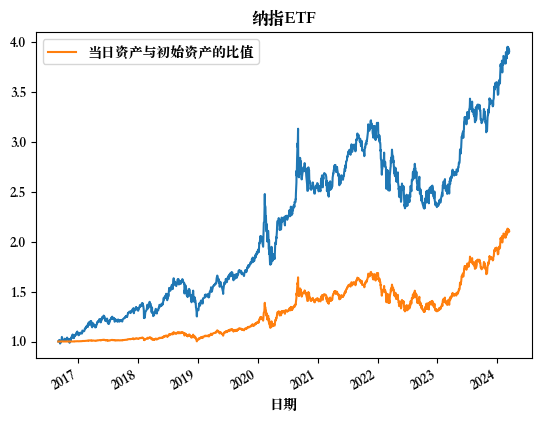

In [75]:
# 以房地产 ETF、标普 500 ETF 和纳指 ETF 为例
for i in [0, 12, 13]:
    calc(stockNameCodes[i], datetime.timedelta(days=90))
    plt.show()

In [76]:
deltas = [
    datetime.timedelta(days=1),
    datetime.timedelta(days=2),
    datetime.timedelta(days=3),
    datetime.timedelta(days=7),
    datetime.timedelta(days=15),
    datetime.timedelta(days=30),
    datetime.timedelta(days=90),
    datetime.timedelta(days=180),
    datetime.timedelta(days=365)
]
res: list[pd.DataFrame] = []
for stockNameCode in stockNameCodes:
    l: list[pd.DataFrame] = []
    for delta in deltas:
        final, ratio, extra = calc(stockNameCode, delta, silent=True)
        l.append(pd.DataFrame({"标的": stockNameCode[1], "投资周期": [delta], "价格比例": [ratio],
                               "资产比例": [final], "额外费用": [extra]}, columns=["标的", "投资周期", "价格比例", "资产比例", "额外费用"]))
    res.append(pd.concat(l))

In [93]:
# ax = plt.axes(title='不同投资周期下对不同标的进行投资得到的资产比例')
table: list[pd.DataFrame] = []
for i, l in enumerate(res):
    # l.plot(ax=ax, x='投资周期', y='资产比例', label=stockNameCodes[i][1])
    d = {'标的': stockNameCodes[i][1], }
    for j, delta in enumerate(deltas):
        d[delta.days] = l.iloc[j, 3]
    table.append(pd.DataFrame.from_dict(d, orient='index').T)
# plt.show()

# for i, l in enumerate(res):
#     l.style.format(precision=3)
t = pd.concat(table)
t.style.format(precision=3)

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

#### 计算投资组合


In [78]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# https://pyportfolioopt.readthedocs.io/en/latest/

# df = allStockDaily["512200"]
df = pd.read_csv("../PyPortfolioOpt/tests/resources/stock_prices.csv",
                 parse_dates=True, index_col="date")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
w = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

print(ef.clean_weights())

Expected annual return: 30.5%
Annual volatility: 22.2%
Sharpe Ratio: 1.28
OrderedDict([('GOOG', 0.03835), ('AAPL', 0.0689), ('FB', 0.20603), ('BABA', 0.07315), ('AMZN', 0.04033), ('GE', 0.0), ('AMD', 0.0), ('WMT', 0.0), ('BAC', 0.0), ('GM', 0.0), ('T', 0.0), ('UAA', 0.0), ('SHLD', 0.0), ('XOM', 0.0), ('RRC', 0.0), ('BBY', 0.01324), ('MA', 0.35349), ('PFE', 0.1957), ('JPM', 0.0), ('SBUX', 0.01082)])


In [79]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(w, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio(verbose=True)
print(allocation)

Funds remaining: 117.27
GOOG: allocated 0.000, desired 0.038
AAPL: allocated 0.069, desired 0.069
FB: allocated 0.209, desired 0.206
BABA: allocated 0.071, desired 0.073
AMZN: allocated 0.072, desired 0.040
GE: allocated 0.001, desired 0.000
AMD: allocated 0.000, desired 0.000
WMT: allocated 0.000, desired 0.000
BAC: allocated 0.000, desired 0.000
GM: allocated 0.000, desired 0.000
T: allocated 0.000, desired 0.000
UAA: allocated 0.000, desired 0.000
SHLD: allocated 0.000, desired 0.000
XOM: allocated 0.000, desired 0.000
RRC: allocated 0.000, desired 0.000
BBY: allocated 0.014, desired 0.013
MA: allocated 0.355, desired 0.353
PFE: allocated 0.196, desired 0.196
JPM: allocated 0.000, desired 0.000
SBUX: allocated 0.012, desired 0.011
Allocation has RMSE: 0.011
{'AAPL': 8, 'FB': 25, 'BABA': 8, 'AMZN': 1, 'GE': 1, 'AMD': 1, 'SHLD': 1, 'BBY': 4, 'MA': 41, 'PFE': 109, 'SBUX': 4}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
